In [1]:
import pathlib

import pandas as pd
import altair as alt
from altair import datum

alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [2]:
dfs = []
for p in pathlib.Path("results/benchmarks").glob("*.csv"):
    df = (
        pd.read_csv(p)
#         .iloc[:, 1:]
#         .rename_axis("trial")
#         .reset_index()
#         .melt(id_vars="trial", var_name="metric", value_name="seconds")
        .assign(case=p.stem)
        .set_index(["case", "trial"], drop=True)
    )
    dfs.append(df)

In [3]:
df = pd.concat(dfs)

# delta_cols = df.columns[df.columns.str.startswith("initial-")].str.replace("initial-", "delta-")
initial = df.iloc[:, df.columns.str.startswith("initial-")].rename(columns=lambda c: c.replace("initial-", "delta-"))
final = df.iloc[:, df.columns.str.startswith("final-")].rename(columns=lambda c: c.replace("final-", "delta-"))
df = pd.concat([df, final - initial], axis="columns")

df = df.assign(
    workload=df.index.to_frame().case.str.split("-").str[1],
    gc=df.index.to_frame().case.str.split("-").str[2] == "gc",
)

# df = df.loc[["purepy-meantrans-nogc", "purepy-meantrans-gc"]]
df

elapsed    user  nice  system  idle  iowait  \
case                  trial                                                   
purepy-shuffle-nogc   0       52.120259   47.88   0.0    2.27  2.46    0.00   
                      1       53.346628   49.68   0.0    1.65  2.42    0.00   
                      2       55.209608   51.56   0.0    1.56  2.30    0.00   
                      3       57.548897   53.76   0.0    1.77  2.27    0.00   
                      4       59.688898   55.54   0.0    1.85  2.54    0.01   
                      5       60.428049   56.72   0.0    1.71  2.28    0.00   
                      6       62.973510   59.12   0.0    1.74  2.51    0.00   
                      7       65.209641   61.42   0.0    1.68  2.56    0.00   
                      8       65.983176   61.63   0.0    1.95  2.52    0.00   
                      9       66.291250   62.75   0.0    1.68  2.10    0.00   
purepy-meantrans-gc   0       63.949811   55.04   0.0    3.15  5.14    0.00   
                      1       61.635613   53.57   0.0    2.37  4.83    0.00   
                      2       62.382710   55.07   0.0    2.05  4.77    0.00   
                      3       67.725629   59.96   0.0    2.34  4.95    0.00   
                      4       72.949748   65.07   0.0    2.45  5.00    0.00   
                      5       72.404575   64.83   0.0    1.87  4.96    0.00   
                      6       76.889667   68.96   0.0    1.95  4.78    0.00   
                      7       81.196706   73.49   0.0    2.04  4.96    0.00   
                      8      106.400848   98.15   0.0    2.63  4.36    0.05   
                      9      118.470076  110.16   0.0    3.03  4.22    0.00   
purepy-shuffle-gc     0       88.556207   82.44   0.0    2.75  4.27    0.00   
                      1       97.915963   94.10   0.0    1.86  2.83    0.01   
                      2      104.750765   99.08   0.0    1.74  4.74    0.00   
                      3      111.855253  108.32   0.0    1.73  2.89    0.00   
                      4      121.684416  117.60   0.0    1.88  2.93    0.01   
                      5      124.850819  120.67   0.0    1.95  3.04    0.00   
                      6      133.812773  126.19   0.0    1.90  6.63    0.00   
                      7      139.952112  131.95   0.0    2.03  6.43    0.00   
                      8      143.240422  138.14   0.0    2.50  3.11    0.00   
                      9      152.386610  143.59   0.0    2.18  6.98    0.00   
purepy-meantrans-nogc 0       29.631958   24.05   0.0    1.72  4.30    0.00   
                      1       28.748236   23.73   0.0    1.47  3.99    0.00   
                      2       29.600939   24.37   0.0    1.67  3.74    0.00   
                      3       29.850555   24.65   0.0    1.49  3.85    0.00   
                      4       30.726024   25.63   0.0    1.49  3.84    0.00   
                      5       32.873134   27.28   0.0    1.56  5.32    0.00   
                      6       33.423248   26.58   0.0    1.63  5.86    0.00   
                      7       33.665817   28.04   0.0    1.56  5.91    0.00   
                      8       34.916862   28.05   0.0    1.50  6.02    0.00   
                      9       32.797120   27.55   0.0    1.57  4.01    0.00   

                             irq  softirq  steal  guest  ...  final-dirty  \
case                  trial                              ...                
purepy-shuffle-nogc   0      0.0     0.84   0.01    0.0  ...            0   
                      1      0.0     0.95   0.01    0.0  ...            0   
                      2      0.0     1.04   0.01    0.0  ...            0   
                      3      0.0     1.03   0.01    0.0  ...            0   
                      4      0.0     0.89   0.01    0.0  ...            0   
                      5      0.0     0.89   0.01    0.0  ...            0   
                      6      0.0     1.08   0.01    0.0  ...            0   
                    

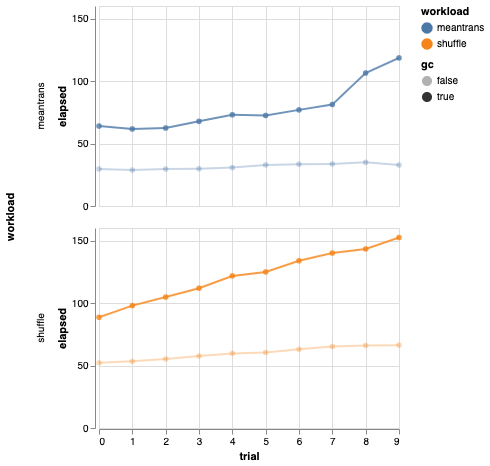

In [4]:
elapsed = alt.Chart(
    df.reset_index(),
    height=200,
    width=300,
).encode(
    x="trial", y="elapsed", color="workload", opacity="gc", row="workload", tooltip=["case", "trial", "elapsed"]
).mark_line(point=True)
elapsed

In [5]:
import dask

In [6]:
# cpu = df.iloc[:, 1:11]
cpu = df[["user", "system", "idle", "workload", "gc"]]
mem = (
#     df.iloc[:, 12:19]
    (df[["initial-rss", "initial-data", "initial-shared", "initial-text"]] / dask.utils.parse_bytes("1GiB"))
    .join(df[["gc", "workload"]])
    .rename(columns=lambda c: c.replace("initial-", ""))
)

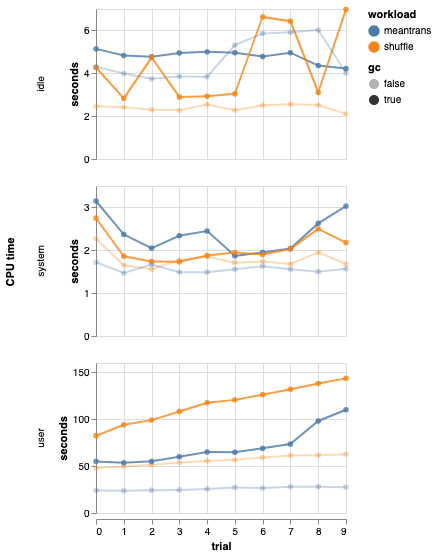

In [7]:
cpu_chart = (
    alt.Chart(
        cpu.melt(ignore_index=False, id_vars=["workload", "gc"], var_name="CPU time", value_name="seconds").reset_index(),
        height=150,
        width=250,
    )
    .encode(x="trial", y="seconds", color="workload", opacity="gc", row="CPU time", tooltip=["case", "seconds"])
    .mark_line(point=True)
    .resolve_scale(y='independent')
)
cpu_chart

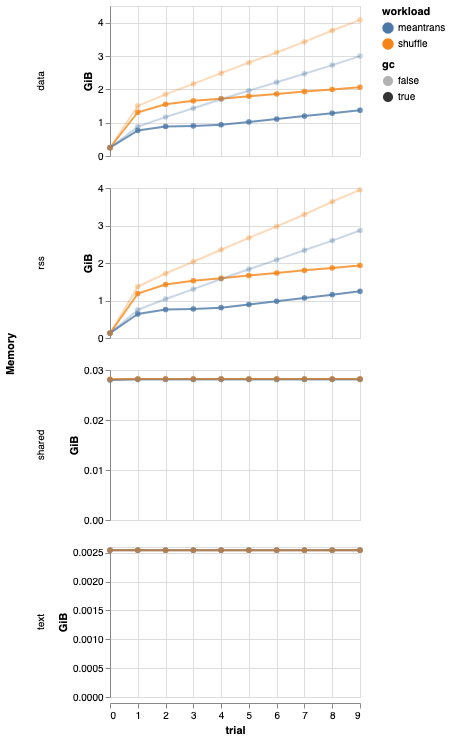

In [8]:
mem_chart = (
    alt.Chart(
        mem.melt(ignore_index=False, id_vars=["workload", "gc"], var_name="Memory", value_name="GiB").reset_index(),
        height=150,
        width=250,
    )
    .encode(x="trial", y="GiB", color="workload", opacity="gc", row="Memory", tooltip=["case", "GiB"])
    .mark_line(point=True)
    .resolve_scale(y='independent')
)
mem_chart

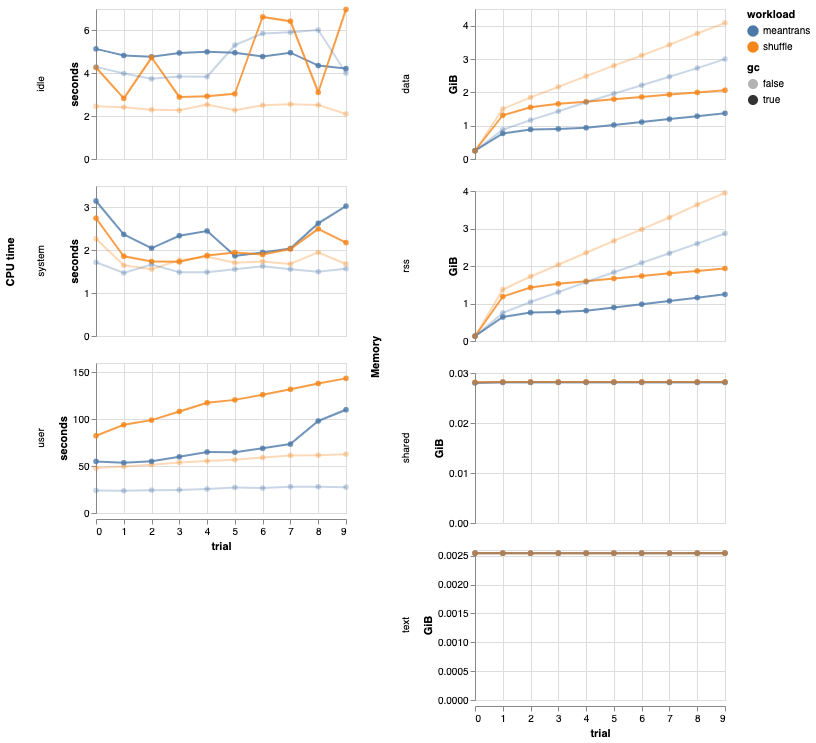

In [9]:
cpu_chart | mem_chart

In [10]:
def percent_improvement(before="purepy-shuffle-gc", after="purepy-shuffle-nogc", i_before=0, i_after=0):
    before = df["elapsed"].loc[(before, i_before)]
    after = df["elapsed"].loc[(after, i_after)]
    return -100 * (after - before) / before

In [11]:
percent_improvement()

41.14443090281052

In [12]:
percent_improvement(i_before=9, i_after=9)

56.4979827161546

In [14]:
percent_improvement("purepy-meantrans-gc", "purepy-meantrans-nogc")

53.663728587525995

In [15]:
percent_improvement("purepy-meantrans-gc", "purepy-meantrans-nogc", i_before=9, i_after=9)

72.31611425904455

In [16]:
percent_improvement(before="purepy-shuffle-gc", after="purepy-shuffle-gc", i_before=0, i_after=9)

-72.07897263097924